Problem Multi-objective optimization problem
=============================================

In this example, we will search for a multi-resonant gold nano-structure. The structure we seek has two specific plasmon resonances, $\lambda_1 = 700\,$nm for polarization along *X* and  $\lambda_2 = 1300\,$nm for an incident polarization along *Y*. We will determine if a plasmon resonance exists via the scattering efficiency of the structure.


Load the modules
-------------------

In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import linear
from pyGDM2 import tools

from pyGDM2 import core

from pyGDM2.EO.models import RectangularAntenna, CrossAntenna
from pyGDM2.EO.core import run_eo

Define a multi-objective problem
--------------------------------------

Now we need to define our multi-objective problem. We do this by inheriting from *EO.problems.BaseProblem* and overriding *objective_function*:

In [2]:
from pyGDM2.EO.problems import BaseProblem

class ownMultiObjectiveProblem(BaseProblem):
    """maximize scattering efficiency (Q_sc) of nano-structure at two wavelengths"""
    
    def __init__(self, model):
        """
        In the Problem constructor, the constructor of the parent 
        class "BaseProblem" must be called, passing the `model` object.:
        """
        super(self.__class__, self).__init__(model)
        
    
    def objective_function(self, params):
        """calculate the scat. efficiency for 2 incident field configs
        
        This method implements the multi-objective problem: 
        The objective function returns an array with several objective
        function values (the "objective vector").
        Just as in a single-objective scenario, `objective_function` 
        is function of the free parameters `params`.
        
        Use the `field_index` parameter to select the different incident
        field configurations. In this example problem we use the first
        and last available `field_index`.
        
        """
        ## --- generate the structure geometry as function of `params`
        self.model.generate_structure(params)
        
        ## --- GDM simulation and cross-section calculation
        core.scatter(self.model.sim, verbose=0)
        
        ## --- calculate scattering efficiency 
        ##     take first and second last field config 
        ##     (e.g. two crossed polarizations at two wavelengths)
        i_field1 = 0 
        i_field2 = len(self.model.sim.E) - 1
        
        ext_cs1, sca_cs1, abs_cs1 = linear.extinct(self.model.sim, field_index=i_field1)
        ext_cs2, sca_cs2, abs_cs2 = linear.extinct(self.model.sim, field_index=i_field2)
        geom_cs = tools.get_geometric_cross_section(self.model.sim)
        
        ## --- scattering efficieny (scat eff. = scat CS / geometric CS)
        return [ float(sca_cs1/geom_cs), float(sca_cs2/geom_cs) ]

Optimization setup
------------------------

The setup of the optimization is straightforward. There are only two small differences to the single-objective optimizations: 

1. we now configure the pyGDM simulation for **two wavelengths and two polarizations**

2. we use an **algorithm which can treat multi-objective problems**. In this example we will use the *pyGMO*-algorithm `moead`

We will also use a slightly more complex geometry model: A cross-like structure, which consists of two "crossed" rectangles, hence possesses four free parameters: two widths and two lengths (we fix the height).


In [3]:
#==============================================================================
# Setup pyGDM part
#==============================================================================
## ---------- Setup structure
mesh = 'cube'
step = 15
material = materials.gold()  # structure material
n1, n2 = 1.0, 1.0            # in vacuum

## --- Empty dummy-geometry, will be replaced on run-time by EO trial geometries
geometry = []       
struct = structures.struct(step, geometry, material, n1,n2, structures.get_normalization(mesh))


## ---------- Setup incident field
field_generator = fields.planewave        # planwave excitation
kwargs = dict(theta = [0, 90])            # 2 polarizations
wavelengths = [700, 1300]                 # 2 wavelengths
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## ---------- Simulation initialization
sim = core.simulation(struct, efield)


#==============================================================================
# setup evolutionary optimization
#==============================================================================
## --- output folder and file-names
results_folder = 'eo_out'
results_suffix = 'test_MO_problem'

## --- structure model and optimization problem
limits_W   = [2, 20]
limits_L   = [2, 20] 
limits_pos = [-1, 1]
height = 3
model = CrossAntenna(sim, limits_W, limits_L, limits_pos, height)

problem = ownMultiObjectiveProblem(model)


## --- filename to save results 
results_filename = 'emo_test.eo'

## --- size of population
population = 100         # Nr of individuals

## --- stop criteria
max_time = 1800          # seconds
max_iter = 50            # max. iterations
max_nonsuccess = 10      # max. consecutive iterations without improvement

## --- other config
generations = 1          # generations to evolve between status reports
plot_interval = 1
save_all_generations = True

##  Use multi-objective algorithm "nsga2"
import pygmo as pg
algorithm = pg.moead
algorithm_kwargs = dict(weight_generation='low discrepancy', 
                        decomposition='weighted')  # optional algo. kwargs

/home/wiecha/.local/lib/python2.7/site-packages/pyGDM2/structures.py:119: UserWarning: Emtpy structure geometry.
  warnings.warn("Emtpy structure geometry.")
/home/wiecha/.local/lib/python2.7/site-packages/pyGDM2/structures.py:104: UserWarning: Minimum structure Z-value lies below substrate level! Shifting structure bottom to Z=step/2.
  " Shifting structure bottom to Z=step/2.")


Now we

Run the multi-objective optimization
-------------------------------------


----------------------------------------------
 Starting new optimization
----------------------------------------------


iter #  1, time:  106.0s, progress #  1, f_evals: 200 


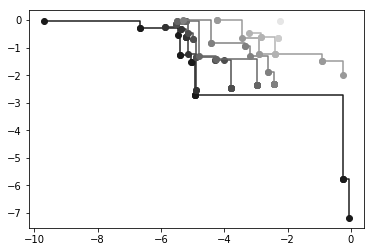

        - ideal: [-9.6864, -7.1887]  (= minimum objective values)
        - nadir: [-0.074154, -0.027323]  (= maximum objective values)
        - 9 fronts, length best front: 16

iter #  2, time:  263.1s, progress #  2, f_evals: 300 


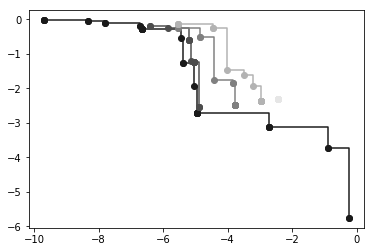

        - ideal: [-9.6864, -5.7582]  (= minimum objective values)
        - nadir: [-0.25012, -0.027323]  (= maximum objective values)
        - 5 fronts, length best front: 34

iter #  3, time:  365.1s, progress #  3, f_evals: 400 


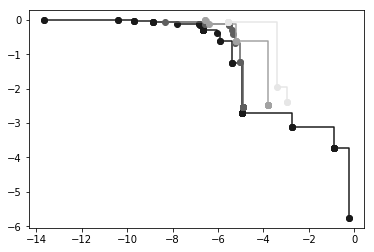

        - ideal: [-13.661, -5.7582]  (= minimum objective values)
        - nadir: [-0.25012, -0.0073882]  (= maximum objective values)
        - 4 fronts, length best front: 58

iter #  4, time:  437.2s, progress #  4, f_evals: 500 


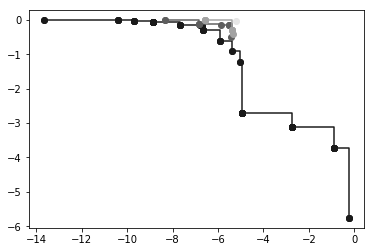

        - ideal: [-13.661, -5.7582]  (= minimum objective values)
        - nadir: [-0.25012, -0.0073882]  (= maximum objective values)
        - 4 fronts, length best front: 80

iter #  5, time:  489.5s, progress #  5, f_evals: 600 


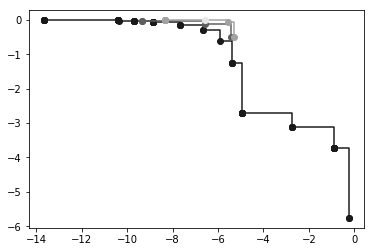

        - ideal: [-13.661, -5.7582]  (= minimum objective values)
        - nadir: [-0.25012, -0.0073882]  (= maximum objective values)
        - 4 fronts, length best front: 89

iter #  6, time:  537.2s, progress #  6, f_evals: 700 


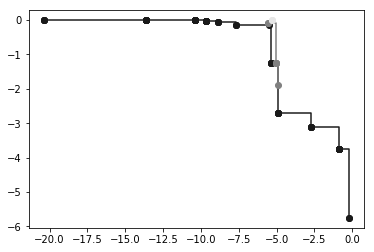

        - ideal: [-20.354, -5.7582]  (= minimum objective values)
        - nadir: [-0.25012, -0.0026561]  (= maximum objective values)
        - 3 fronts, length best front: 91

iter #  7, time:  578.6s, progress #  7, f_evals: 800 


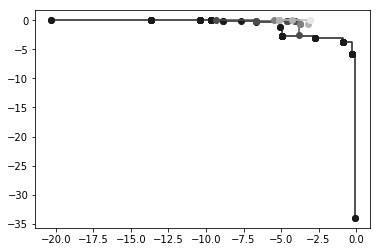

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 5 fronts, length best front: 80

iter #  8, time:  630.3s, progress #  8, f_evals: 900 


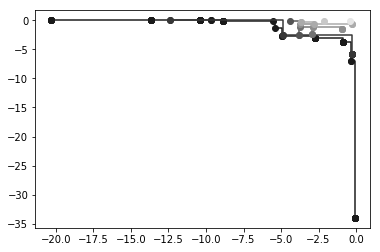

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 8 fronts, length best front: 64

iter #  9, time:  678.5s, progress #  9, f_evals: 1000 


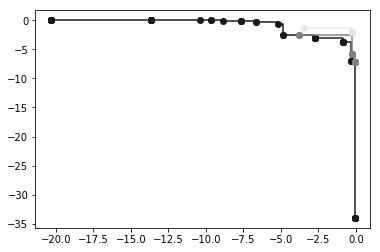

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 3 fronts, length best front: 84

iter # 10, time:  713.6s, progress # 10, f_evals: 1100 


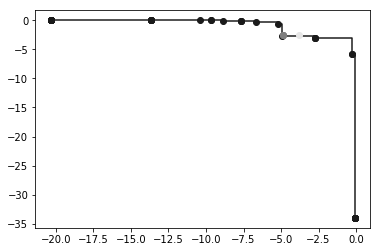

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 3 fronts, length best front: 96

iter # 11, time:  748.4s, progress # 11, f_evals: 1200 


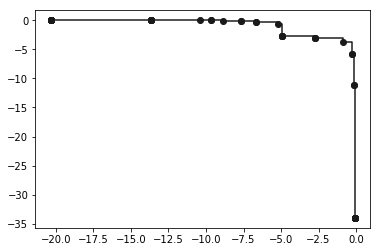

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 1 fronts, length best front: 100

iter # 12, time:  781.4s, progress # 12, f_evals: 1300 


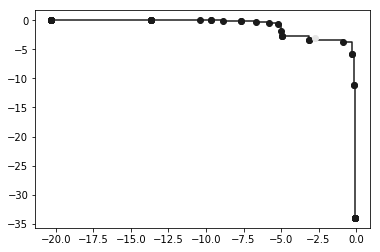

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 99

iter # 13, time:  815.4s, progress # 12, f_evals: 1400 (non-success: 1)
iter # 14, time:  851.5s, progress # 12, f_evals: 1500 (non-success: 2)
iter # 15, time:  883.4s, progress # 12, f_evals: 1600 (non-success: 3)
iter # 16, time:  916.7s, progress # 13, f_evals: 1700 


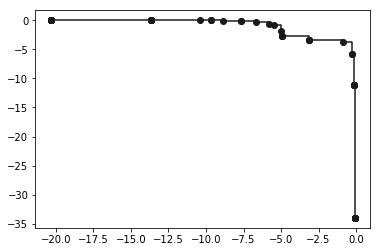

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 1 fronts, length best front: 100

iter # 17, time:  950.3s, progress # 14, f_evals: 1800 


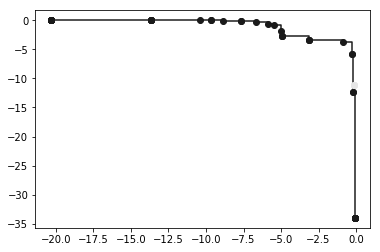

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 97

iter # 18, time:  987.6s, progress # 15, f_evals: 1900 


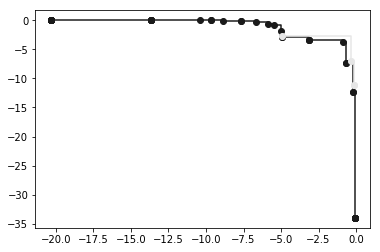

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 96

iter # 19, time: 1022.5s, progress # 16, f_evals: 2000 


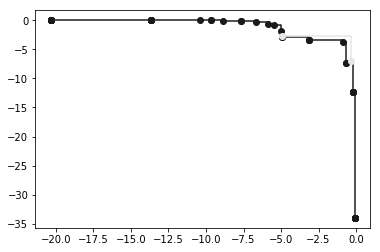

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 98

iter # 20, time: 1057.5s, progress # 17, f_evals: 2100 


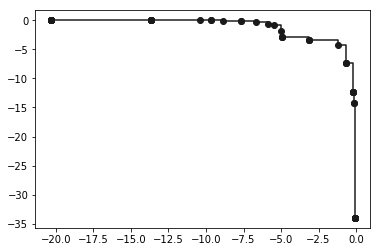

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 1 fronts, length best front: 100

iter # 21, time: 1091.4s, progress # 17, f_evals: 2200 (non-success: 1)
iter # 22, time: 1125.2s, progress # 18, f_evals: 2300 


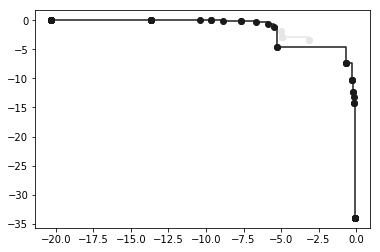

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 94

iter # 23, time: 1157.1s, progress # 19, f_evals: 2400 


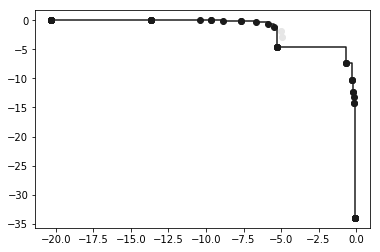

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 98

iter # 24, time: 1189.0s, progress # 20, f_evals: 2500 


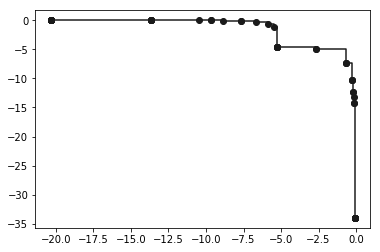

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 1 fronts, length best front: 100

iter # 25, time: 1239.4s, progress # 20, f_evals: 2600 (non-success: 1)
iter # 26, time: 1270.8s, progress # 21, f_evals: 2700 


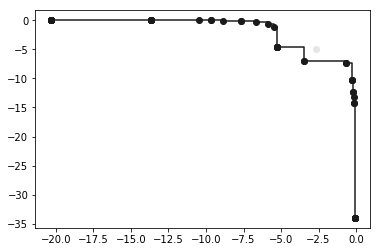

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 99

iter # 27, time: 1302.9s, progress # 22, f_evals: 2800 


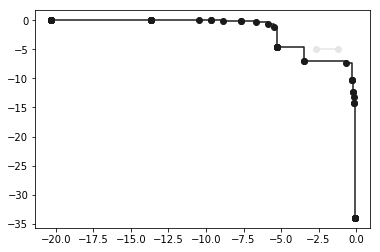

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 98

iter # 28, time: 1335.1s, progress # 22, f_evals: 2900 (non-success: 1)
iter # 29, time: 1364.8s, progress # 22, f_evals: 3000 (non-success: 2)
iter # 30, time: 1394.5s, progress # 23, f_evals: 3100 


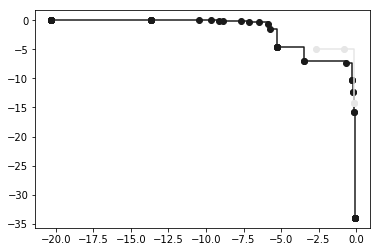

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 96

iter # 31, time: 1425.2s, progress # 23, f_evals: 3200 (non-success: 1)
iter # 32, time: 1455.4s, progress # 23, f_evals: 3300 (non-success: 2)
iter # 33, time: 1485.5s, progress # 23, f_evals: 3400 (non-success: 3)
iter # 34, time: 1515.1s, progress # 23, f_evals: 3500 (non-success: 4)
iter # 35, time: 1545.1s, progress # 23, f_evals: 3600 (non-success: 5)
iter # 36, time: 1575.4s, progress # 24, f_evals: 3700 


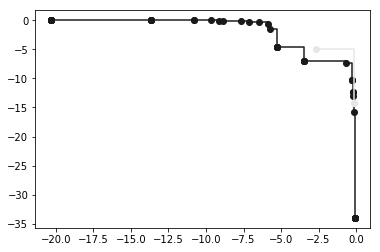

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 97

iter # 37, time: 1606.4s, progress # 25, f_evals: 3800 


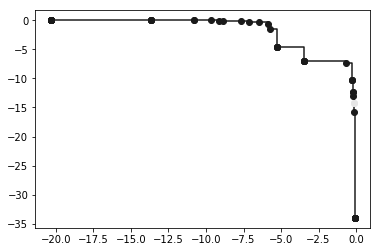

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 98

iter # 38, time: 1637.7s, progress # 26, f_evals: 3900 


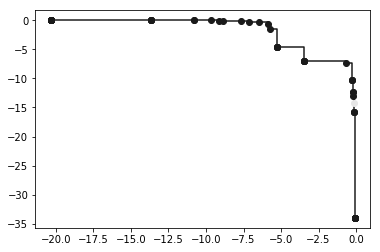

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 2 fronts, length best front: 99

iter # 39, time: 1668.8s, progress # 27, f_evals: 4000 


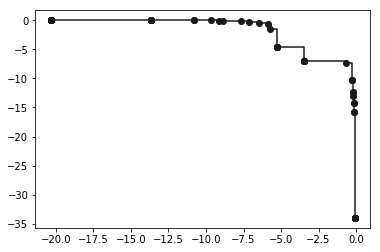

        - ideal: [-20.354, -33.988]  (= minimum objective values)
        - nadir: [-0.079192, -0.0026561]  (= maximum objective values)
        - 1 fronts, length best front: 100

iter # 40, time: 1700.9s, progress # 27, f_evals: 4100 (non-success: 1)
iter # 41, time: 1730.8s, progress # 27, f_evals: 4200 (non-success: 2)
iter # 42, time: 1761.3s, progress # 27, f_evals: 4300 (non-success: 3)
iter # 43, time: 1791.5s, progress # 27, f_evals: 4400 (non-success: 4)
iter # 44, time: 1821.7s, progress # 27, f_evals: 4500 (non-success: 5)

 -------- timelimit reached


In [4]:
eo_dict = run_eo(problem,
                 population=population,
                 algorithm=algorithm,
                 plot_interval=plot_interval, 
                 generations=generations, 
                 max_time=max_time, max_iter=max_iter, max_nonsuccess=max_nonsuccess,
                 filename=results_filename)

Reload and analyze multi-objective results
---------------------------------------------------

Now we will reload the results. What we actually did is a Pareto-multi-objective optimization, which calculates the so-called *Pareto-front*.
The Pareto-front consists of all solutions that cannot be improved in any of the target functions without worsening at least one of the other objective values.

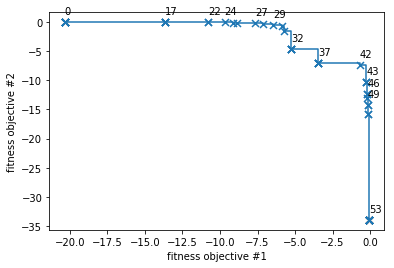

In [5]:
## --- load additional modules
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

from pyGDM2.EO.tools import get_pareto_fronts, plot_pareto_2d, plot_all_pareto_fronts_2d

import numpy as np
import matplotlib.pyplot as plt
import copy


#==============================================================================
# get Pareto-front (set of "Pareto-optima") from optimization
#==============================================================================
filename = "emo_test.eo"

all_paretos, all_sims, all_x = get_pareto_fronts(filename, iteration=-1)

## --- choose "best" Pareto-front (in case several exist):
##     index 0 is the most advanced pareto front --> the optimum solutions
pareto_f = all_paretos[0]
sims_f   = all_sims[0]

## --- plot the pareto front
plot_pareto_2d(pareto_f)

Choose the solutions
----------------------------

Pareto-optimizations return a whole *set* of Pareto-optimum solutions, therefore one has to chose a specific candidate from this set of fittest candidates.
We will select 3 geometries to further analyze: The two solutions on the borders of the Pareto-front, as well as one solution from its center.

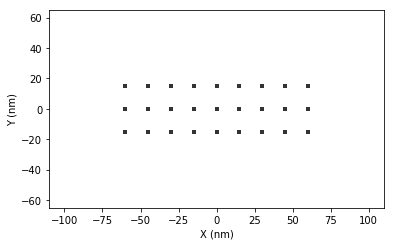

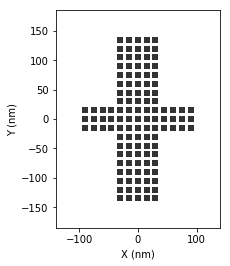

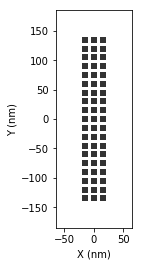

In [6]:
## --- pick 3 Pareto-optimum solutions
sim0 = sims_f[0]
sim1 = sims_f[32]
sim2 = sims_f[-1]

visu.structure(sim0)
visu.structure(sim1)
visu.structure(sim2)

Analyze the Pareto-optimum solutions
-------------------------------------------

In [7]:
## --- structures
struct0 = copy.deepcopy(sim0.struct)
struct1 = copy.deepcopy(sim1.struct)
struct2 = copy.deepcopy(sim2.struct)

## --- incident field
field_generator = fields.planewave        # planwave excitation
wavelengths = np.arange(400, 1610, 20)  # spectrum
kwargs = dict(theta = [0.0, 90.0])          # 0/90 deg polarizations
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## --- spectrum simulations
sim_spec0 = core.simulation(struct0, efield)
sim_spec1 = core.simulation(struct1, efield)
sim_spec2 = core.simulation(struct2, efield)

## --- run the simulations
_e = core.scatter(sim_spec0, verbose=False)
_e = core.scatter(sim_spec1, verbose=False)
_e = core.scatter(sim_spec2, verbose=False)

Calculate scattering spectra
--------------------------------

We now calculate the scattering efficiency spectra for the three selected structures:

In [8]:
## -- structure #0
wl, _ext0 = tools.calculate_spectrum(sim_spec0, 0, linear.extinct)
wl, _ext90 = tools.calculate_spectrum(sim_spec0, 1, linear.extinct)
geom_cs = tools.get_geometric_cross_section(sim_spec0)
Qs0_X = _ext0.T[1] / geom_cs
Qs0_Y = _ext90.T[1] / geom_cs

## -- structure #1
wl, _ext0 = tools.calculate_spectrum(sim_spec1, 0, linear.extinct)
wl, _ext90 = tools.calculate_spectrum(sim_spec1, 1, linear.extinct)
geom_cs = tools.get_geometric_cross_section(sim_spec1)
Qs1_X = _ext0.T[1] / geom_cs
Qs1_Y = _ext90.T[1] / geom_cs

## -- structure #2
wl, _ext0 = tools.calculate_spectrum(sim_spec2, 0, linear.extinct)
wl, _ext90 = tools.calculate_spectrum(sim_spec2, 1, linear.extinct)
geom_cs = tools.get_geometric_cross_section(sim_spec2)
Qs2_X = _ext0.T[1] / geom_cs
Qs2_Y = _ext90.T[1] / geom_cs

Plot the spectra
-----------------------

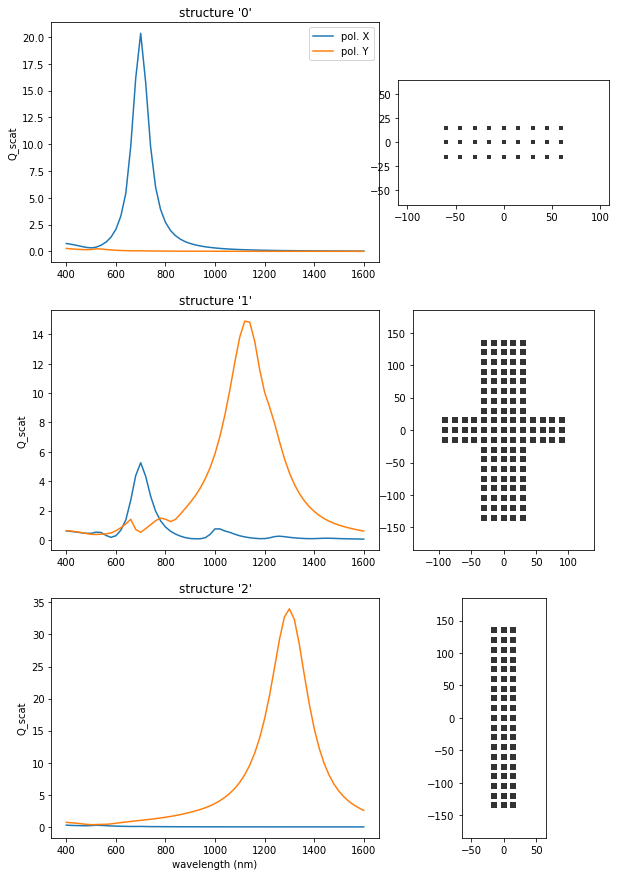

In [9]:
plt.figure(figsize=(10,15))

## --- structure 0
## spectra
plt.subplot2grid((3,5), (0,0), colspan=3)
plt.title("structure '0'")
plt.plot(wl, Qs0_X, label="pol. X")
plt.plot(wl, Qs0_Y, label="pol. Y")
plt.ylabel("Q_scat")
plt.legend(loc='best', fontsize=10)

## geometry
plt.subplot2grid((3,5), (0,3), colspan=2, aspect="equal")
visu.structure(sim_spec0, show=False)

          
## --- structure 1
## spectra
plt.subplot2grid((3,5), (1,0), colspan=3)
plt.title("structure '1'")
plt.plot(wl, Qs1_X, label="pol. X")
plt.plot(wl, Qs1_Y, label="pol. Y")
plt.ylabel("Q_scat")
          
## geometry
plt.subplot2grid((3,5), (1,3), colspan=2, aspect="equal")
visu.structure(sim_spec1, show=False)

          
## --- structure 2
## spectra
plt.subplot2grid((3,5), (2,0), colspan=3)
plt.title("structure '2'")
plt.plot(wl, Qs2_X, label="pol. X")
plt.plot(wl, Qs2_Y, label="pol. Y")
plt.xlabel("wavelength (nm)")
plt.ylabel("Q_scat")

## geometry
plt.subplot2grid((3,5), (2,3), colspan=2, aspect="equal")
visu.structure(sim_spec2, show=False)

    
plt.show()

The structures on the "border" of the Pareto-front are equivalent to single-objective optimizations for either of the two target functions:

- Structure "0" corresponds to a maximization of $Q_{\text{scat}}$ for 1300nm and *Y* polarization

- Structure "2" corresponds to a maximization of $Q_{\text{scat}}$ for 700nm and *X* polarization

Structure "1" is the most interesting result: We take the structure on the Pareto-Front with most similar $Q_{\text{scat}}$ for the two target configurations, and indeed, the optimization found a double-resonant structure, with addressable resonances via a rotation of the incident light polarization. 

*Note:* The size-limit of $20$ meshpoints in each dimension seems to be slightly too small to obtain a resonance at $\lambda=1300\,$nm in the double-resonant case.